<a href="https://colab.research.google.com/github/hahw94/DNN-ResNet-etc/blob/master/3_DNN_%EB%AA%A8%EB%8D%B8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# (코랩) DNN 모델
- 참고 논문 ( Deep Learning Architecture for Estimating
Hourly Ground-Level PM2.5 Using
Satellite Remote Sensing)
- 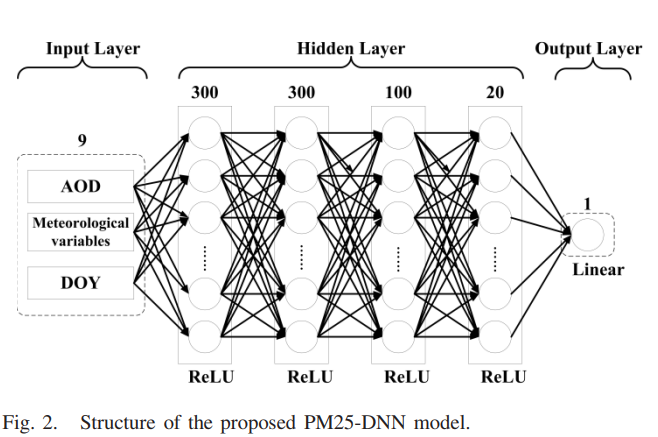

# 1. 구글 드라이브 저장소 마운트 및 사용 할 라이브러리 불러오기
- 코랩에서 진행할 경우 위의 목록창에서 [런타임 -> 런타임 유형변경 -> 하드웨어 가속기 -> GPU]로 설정을 미리 해주셔야합니다.

In [1]:
from google.colab import drive 
drive.mount('/gdrive')
# 구글 드라이브 저장소 마운트 하기
# skorch는 코랩에 설치가 안되있어 따로 설치해주시고 넘어가야합니다.

Mounted at /gdrive


In [2]:
pip install skorch

     |████████████████████████████████| 133kB 2.8MB/s 


In [3]:
import time
import torch
# pytorch(인공지능 관련 모델 라이브러리)
import numpy as np
# numpy(통계 라이브러리)
import pandas as pd
# pandas(통계 라이브러리 -> R의 통계 기능을 많이 가져옴)

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
# torch에서도 많이 쓰는 기능들의 변수를 따로 지정

from torchvision import datasets, transforms
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

import numpy as np
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from skorch import NeuralNetRegressor

from sklearn.model_selection import cross_val_predict

from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

torch.manual_seed(0);

import numpy as np
import torch
from skorch import NeuralNetBinaryClassifier
from skorch.dataset import CVSplit
from skorch.callbacks import EarlyStopping
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate

import matplotlib.pyplot as plt

# 2. 사용할 데이터 불러오기
- 지난번 다중선형회귀모델의 결과를 토대로 만들었던 결과 파일을 불러오도록 하겠습니다.
- 이후 학습에 사용되는 input과 Target(PM10)을 나누어보겠습니다.

In [4]:
file_path = "/gdrive/My Drive/Colab Notebooks/Model/Result/"
filename = "PM10_norm_dropna.csv"

In [5]:
data = pd.read_csv(file_path + filename)
data.head()

,Unnamed: 0,AOD,CO,DAI,NO2,O3,PBLH,PM10,month,tcc,temp,wd,ws,year
0,8603,0.064560,0.263158,0.640191,0.04,0.113636,0.367017,80.0,0.0,0.00626,0.141561,0.805556,0.518987,0.0
1,8605,0.036473,0.263158,0.678486,0.05,0.125000,0.374501,48.0,0.0,0.01563,0.172414,0.888889,0.708861,0.0
2,8606,0.049356,0.210526,0.682834,0.05,0.130682,0.382192,39.0,0.0,0.03061,0.186933,0.805556,0.670886,0.0
3,8611,0.057828,0.315789,0.543203,0.12,0.079545,0.299127,28.0,0.0,0.20934,0.188748,0.750000,0.379747,0.0
4,8612,0.056697,0.368421,0.637802,0.16,0.062500,0.392486,27.0,0.0,0.00311,0.215971,0.750000,0.582278,0.0


In [6]:
temp_x = data[data.columns.difference(['Unnamed: 0','PM10'])]
temp_y = data["PM10"]

In [7]:
temp_x
# input 데이터

,AOD,CO,DAI,NO2,O3,PBLH,month,tcc,temp,wd,ws,year
0,0.064560,0.263158,0.640191,0.04,0.113636,0.367017,0.0,0.00626,0.141561,0.805556,0.518987,0.0
1,0.036473,0.263158,0.678486,0.05,0.125000,0.374501,0.0,0.01563,0.172414,0.888889,0.708861,0.0
2,0.049356,0.210526,0.682834,0.05,0.130682,0.382192,0.0,0.03061,0.186933,0.805556,0.670886,0.0
3,0.057828,0.315789,0.543203,0.12,0.079545,0.299127,0.0,0.20934,0.188748,0.750000,0.379747,0.0
4,0.056697,0.368421,0.637802,0.16,0.062500,0.392486,0.0,0.00311,0.215971,0.750000,0.582278,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
4669,0.058641,0.157895,0.634312,0.12,0.164773,0.327407,1.0,0.00000,0.324864,0.888889,0.303797,1.0
4670,0.104167,0.315789,0.587619,0.36,0.022727,0.072327,1.0,0.00000,0.310345,0.194444,0.202532,1.0
4671,0.094853,0.263158,0.587209,0.32,0.039773,0.118681,1.0,0.27063,0.337568,0.194444,0.189873,1.0
4672,0.086264,0.263158,0.516945,0.32,0.039773,0.152877,1.0,0.69937,0.366606,0.194444,0.189873,1.0


In [8]:
temp_y
# Target 데이터 

0       80.0
1       48.0
2       39.0
3       28.0
4       27.0
        ... 
4669    31.0
4670    45.0
4671    44.0
4672    39.0
4673    49.0
Name: PM10, Length: 4674, dtype: float64

- 신경망에서 학습을 시키기 위해서는 array라는 데이터의 형식으로 바꾸어주어야합니다.

In [9]:
  X = np.array(temp_x, dtype=np.float32)
  y = np.array(temp_y, dtype=np.float32)
  # 반드시 여기처럼 float32형으로 데이터 타입을 지정해주어야합니다.

In [10]:
print(X.shape, y.shape)
# X는 2차원 y는 1차원으로 차원을 X처럼 맞춰주기 위해 y의 차원을 늘려주어야합니다.

(4674, 12) (4674,)


In [11]:
y = np.expand_dims(y, axis=1)
# np.expand_dims 함수를 사용하면 원하는 차원을 하나 늘릴 수 있습니다
# 다음과 같이 하면 y의 차원이 하나 늘어나게 됩니다.

In [12]:
print(X.shape, y.shape)
# y의 차원이 하나 늘어난것을 볼 수 있습니다.

(4674, 12) (4674, 1)


In [13]:
train_x, test_x, train_y, test_y = train_test_split(X,y,train_size = 0.7, test_size = 0.3)
# train_test_split함수를 사용하여 훈련 및 테스트 데이터를 나누어줍니다.
# 여기서는 train을 70% test를 30%로 지정하였습니다.

- 함수로 간소화 하기

In [14]:
def read_dataset(data_path, file_name, train_size, test_size):
  data = pd.read_csv(file_path + filename)
  temp_x = data[data.columns.difference(['Unnamed: 0','PM10'])]
  temp_y = data["PM10"]
  X = np.array(temp_x, dtype=np.float32)
  y = np.array(temp_y, dtype=np.float32)
  y = np.expand_dims(y, axis=1)
  train_x, test_x, train_y, test_y = train_test_split(X,y,train_size = 0.7, test_size = 0.3)
  return train_x, test_x, train_y, test_y
# 불러올 데이터와 파일 이름, 훈련과 테스트 비율만 설정해주면 됩니다.

In [15]:
# 위에서 했던 과정을 똑같이 해보면 다음과 같이 줄일 수 있습니다.
file_path = "/gdrive/My Drive/Colab Notebooks/Model/Result/"
filename = "PM10_norm_dropna.csv"
train_size = 0.7
test_size = 0.3
train_x, test_x, train_y, test_y = read_dataset(file_path, filename, train_size, test_size)

In [16]:
print(train_x.shape, test_x.shape, train_y.shape, test_y.shape)

(3271, 12) (1403, 12) (3271, 1) (1403, 1)


# 3. DNN Model(by SKORCH)
- skorch라는 통계와 파이토치를 합친 라이브러리를 이용하여 간단하게 모델을 구성해보겠습니다.
- 아래의 사진과 비슷한 신경망으로 구성해보았습니다(input data 에서는 조금 차이가 있습니다)

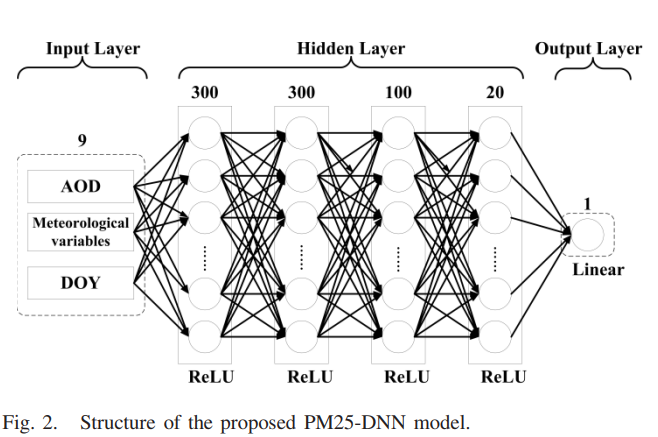

In [17]:
class DNN_Network(nn.Module):
    def __init__(self):
        super(DNN_Network, self).__init__()
        self.fc1 = nn.Linear(12, 300)
        self.fc2 = nn.Linear(300, 300)
        self.fc3 = nn.Linear(300, 100)
        self.fc4 = nn.Linear(100, 20)
        self.output = nn.Linear(20, 1)
        self.dropout = 0.1
        self.dropout = nn.Dropout(0.2)

    def forward(self, x, **kwargs):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        x = self.output(x)
        return x

In [18]:
net = NeuralNetRegressor(DNN_Network, max_epochs = 150, lr = 0.00004, optimizer__momentum=0.9, batch_size = 128, device = 'cuda')
# input data는 반드시 2d 데이터여만 합니다
# 함수의 첫번째 변수 DNN_Network는 사용할 신경망(위에서 만든것), max_epochs는 신경망을 돌릴 최대횟수(아래 예시처럼 콜백을 사용하면 얼리스타핑을 사용할수 있습니다(오버피팅 전 학습을 멈추기 위한 방법 중 하나))
# optimzer_momentum은 관성과 같은 역할을 하며 극솟값에 빠지지 않고 최소값으로 갈 수 있게 해주는 장치입니다.
# batch_szie는 한번에 학습시킬 데이터의 갯수로 크기가 커질수록 학습속도는 빨라지며 어느정도의 오버피팅을 막아주지만 너무 크게 설정할시에는 정확도 높은 학습이 이루어지지 않습니다.
# devie는 사용할 장치를 설정하며 gpu 사용시(엔비디아 그래픽카드만 가능) 'cuda'로 cpu사용시에는 'cpu'로 설정하면 됩니다.
# net = NeuralNetRegressor(DNN_Network, max_epochs = 2000, lr = 0.000008, optimizer__momentum=0.8, batch_size = 128, callbacks=[EarlyStopping(patience=300)], device = 'cuda')

In [19]:
net.fit(train_x, train_y)

  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1     3054.0836     3314.5918  0.2195
      2     2959.8159     3159.5102  0.0952
      3     2233.3043     1815.3850  0.0938
      4     1149.1717     1314.8718  0.0978
      5      879.8834     1134.8921  0.0965
      6      782.4831     1066.7234  0.0934
      7      754.9687     1038.6505  0.0944
      8      736.1421     1031.1386  0.1072
      9      725.3447     1029.7322  0.1273
     10      715.6531     1020.5522  0.1225
     11      704.3572      999.7234  0.1303
     12      690.5661      980.0927  0.1253
     13      677.6481      966.7647  0.1274
     14      667.9779      956.4542  0.1244
     15      660.9421      947.7534  0.1249
     16      655.9611      941.3738  0.1060
     17      653.2039      937.2310  0.0953
     18      653.3382      935.6121  0.0976
     19      655.6317      936.3705  0.1142
     20      656.6077      923.6137  0.0947
     21      651.6551      904.3

<class 'skorch.regressor.NeuralNetRegressor'>[initialized](
  module_=DNN_Network(
    (fc1): Linear(in_features=12, out_features=300, bias=True)
    (fc2): Linear(in_features=300, out_features=300, bias=True)
    (fc3): Linear(in_features=300, out_features=100, bias=True)
    (fc4): Linear(in_features=100, out_features=20, bias=True)
    (output): Linear(in_features=20, out_features=1, bias=True)
    (dropout): Dropout(p=0.2, inplace=False)
  ),
)

In [20]:
r2 = r2_score(train_y[:,0], net.predict(train_x)[:,0])
train_frame = pd.DataFrame()
train_frame["Observe"] = train_y[:,0]
train_frame["predict"] = net.predict(train_x)[:,0]
r = train_frame.corr().iloc[0,1]

print("[train] r2 value is {:.3f}, corr is {:.3f}".format(r2, r))

[train] r2 value is 0.875, corr is 0.936


In [21]:
r2 = r2_score(test_y[:,0], net.predict(test_x)[:,0])
test_frame = pd.DataFrame()
test_frame["Observe"] = test_y[:,0]
test_frame["predict"] = net.predict(test_x)[:,0]
r = test_frame.corr().iloc[0,1]

print("[test] r2 value is {:.3f}, corr is {:.3f}".format(r2, r))

[test] r2 value is 0.618, corr is 0.796


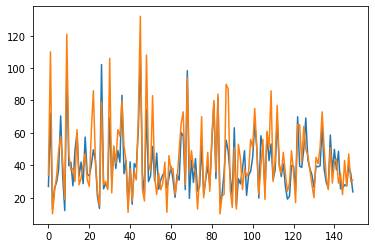

In [22]:
plt.plot(net.predict(train_x)[:,0][:150])
plt.plot(train_y[:,0][:150])
plt.show()

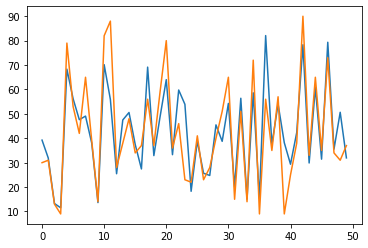

In [23]:
plt.plot(net.predict(test_x)[:,0][1100:1150])
plt.plot(test_y[:,0][1100:1150])
plt.show()

# 5. 가장 좋은 하이퍼 파라미터를 찾기
- https://www.kaggle.com/mlpotter/pytorch-and-skorch-for-deep-learning 
  -> 가장 좋은 하이퍼 파라미터를 찾는 방법이 있음

In [24]:
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import RandomizedSearchCV

In [25]:
class Deep_Residual_Network(nn.Module):
    def __init__(self, num_unit_1 = 210, num_unit_2 = 80, num_unit_3 = 20, drop_out=0.5):
        super(Deep_Residual_Network, self).__init__()
        self.fc1 = nn.Linear(12, num_unit_1)
        self.fc2 = nn.Linear(num_unit_1, num_unit_1)
        self.fc3 = nn.Linear(num_unit_1, num_unit_1)
        self.fc4 = nn.Linear(num_unit_1, num_unit_2)
        self.fc5 = nn.Linear(num_unit_2, num_unit_2)
        self.fc6 = nn.Linear(num_unit_2, num_unit_3)
        self.output = nn.Linear(num_unit_3, 1)
        self.dropout = nn.Dropout(drop_out)

    def forward(self, x, **kwargs):
        fc1 = self.dropout(F.relu(self.fc1(x)))
        fc2 = self.dropout(F.relu(self.fc2(fc1)))
        fc3 = self.dropout(F.relu(self.fc3(fc2)+fc2))
        fc4 = self.dropout(F.relu(self.fc4(fc3)))
        fc5 = self.dropout(F.relu(self.fc5(fc4)+fc4))
        fc6 = self.dropout(F.relu(self.fc6(fc5)))
        fc7 = self.output(fc6)
        return fc7

# 원하는 신경망 구조 클래스를 만듭니다.

In [26]:
net = NeuralNetRegressor(
    Deep_Residual_Network,
#    criterion=nn.MSELoss,
    max_epochs=200,
    optimizer=optim.Adam,
    optimizer__lr = .005
)
# NeuralNetRegressor를 사용해 위에서 만든 클래스를 사용하여 net을 만들어줍니다.

In [27]:
lr = (10**np.random.uniform(-5,-2.5,2)).tolist()
# 위와 같이 일정 범위 사이의 랜덤한 값을 만들어줄수 있습니다.

params = {
    'optimizer__lr': [0.0004,0.0006],
    'max_epochs':[50,100],
    'module__num_unit_1': [200,300],
    #'module__drop_out' : [0,.1,.2,.3,.4]
}
# 확인해보고자 하는 하이퍼파라미터들의 범위를 지정해줍니다.

In [28]:
gs = RandomizedSearchCV(net, params, refit=True, cv=5, scoring='neg_mean_squared_error', n_iter=2)
# RandomizedSearchCV 사용하면 너무 많은 하이퍼파라미터 경우의 수를 확인해야할 때 사용하면 n_iter에 해당하는 숫자만큼 랜덤하게 뽑아 그 횟수만큼 하이퍼파라미터를 확인하게 됩니다.
# cv는 cross validation의 약어입니다.

In [29]:
%%capture
# -> 너무 많이 결과가 출력이 되서 안뜨게 출력
# 실시간으로 잘 진행되는지 확인하고 싶으시면 해당 명령어는 생략하고 진행해주시면됩니다.

start = time.time()
# 시작시간 저장

gs.fit(train_x,train_y)
# fit을 통해서 좋은 하이퍼파라미터를 찾는 RandomizedSearchCV를 진행합니다.

In [30]:
# Utility function to report best scores (found online)
def report(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")


# 위에서 fit한 RandomizedSearchCV에 대한 결과를 보는 코드로 n_top의 갯수만큼 가장 좋았던 하이퍼 파라미터의 구조에 대해서 아래와 같이 출력해줍니다.

In [31]:
# review top 10 results and parameters associated
report(gs.cv_results_,2)

finish = time.time()
# 끝나는 시간
print("걸린시간 : {}분 {:.1f}초".format(int((finish-start)//60), ((finish-start)%60)))

Model with rank: 1
Mean validation score: -785.227 (std: 265.278)
Parameters: {'optimizer__lr': 0.0006, 'module__num_unit_1': 200, 'max_epochs': 50}

Model with rank: 2
Mean validation score: -796.500 (std: 266.917)
Parameters: {'optimizer__lr': 0.0004, 'module__num_unit_1': 300, 'max_epochs': 50}

걸린시간 : 1분 22.1초


# 6. 모델 학습하기
- 5번 과정을 통해 가장 좋은 하이퍼 파라미터의 구조를 알았다면 그것을 토대로 모델을 학습시키면 됩니다.

In [88]:
class Deep_Residual_Network(nn.Module):
    def __init__(self, num_unit_1 = 350, num_unit_2 = 100, num_unit_3 = 20, drop_out=0):
        super(Deep_Residual_Network, self).__init__()
        self.fc1 = nn.Linear(12, num_unit_1)
        self.fc2 = nn.Linear(num_unit_1, num_unit_1)
        self.fc3 = nn.Linear(num_unit_1, num_unit_1)
        self.fc4 = nn.Linear(num_unit_1, num_unit_2)
        self.fc5 = nn.Linear(num_unit_2, num_unit_2)
        self.fc6 = nn.Linear(num_unit_2, num_unit_3)
        self.output = nn.Linear(num_unit_3, 1)
        self.dropout = nn.Dropout(drop_out)

    def forward(self, x, **kwargs):
        fc1 = self.dropout(F.relu(self.fc1(x)))
        fc2 = self.dropout(F.relu(self.fc2(fc1)))
        fc3 = self.dropout(F.relu(self.fc3(fc2)+fc2))
        fc4 = self.dropout(F.relu(self.fc4(fc3)))
        fc5 = self.dropout(F.relu(self.fc5(fc4)+fc4))
        fc6 = self.dropout(F.relu(self.fc6(fc5)))
        fc7 = self.output(fc6)
        return fc7


# 여기서는 위와같이 모델구조를 클래스로 만들어주면 됩니다.

In [89]:
seed = 1
lr = 0.004
momentum = 0.95
no_cuda = False
batch_size = 128
# 배치사이즈와 모멘텀등 몇가지 변수들을 지정해줍니다.

In [90]:
torch.manual_seed(seed)
use_cuda = not no_cuda and torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

In [91]:
model = Deep_Residual_Network().to(device)
optimizer = optim.Adam(model.parameters(), lr=lr)
loss_fn = torch.nn.MSELoss(reduction='sum')
# 모델구조를 만들어 줍니다.

In [92]:
def return_corr():
    r2_pred = model(torch_test_x.cuda()).cpu().detach().numpy()
    r2_target = np.array(torch_test_y)
    df_r2 = pd.DataFrame()
    df_r2['r2_pred'] = r2_pred[:,0]
    df_r2['r2_target'] = r2_target
    return df_r2.corr().iloc[0,1]

# test데이터에 대한 결과를 출력해주는 부분으로 실시간으로 학습하는 모델에 대해 테스트 데이터의 r, r2값을 출력해 줍니다.

In [93]:
torch_train_x = torch.tensor(train_x)
torch_train_y = torch.tensor(train_y)
torch_test_x = torch.tensor(test_x)
torch_test_y = torch.tensor(test_y)

In [94]:
kfold = KFold(n_splits = 3, shuffle = False)
# n_splits만큼 데이터셋을 쪼개서 cross validation과정을 진행하게 됩니다.

In [95]:
def train(network, epochs, save_Model = False):
    max_test_r2_score = 0
    max_test_r_score = 0
    total_acc = 0
    for fold, (train_index, test_index) in enumerate(kfold.split(train_x, train_y)):
        ### Dividing data into folds
        x_train_fold = torch_train_x[train_index]
        x_test_fold = torch_train_x[test_index]
        y_train_fold = torch_train_y[train_index]
        y_test_fold = torch_train_y[test_index]

        train = torch.utils.data.TensorDataset(x_train_fold, y_train_fold)
        test = torch.utils.data.TensorDataset(x_test_fold, y_test_fold)
        train_loader = torch.utils.data.DataLoader(train, batch_size = batch_size, shuffle = False)
        test_loader = torch.utils.data.DataLoader(test, batch_size = batch_size, shuffle = False)

        for epoch in range(epochs):
            print('\nEpoch {} / {} \nFold number {} / {}'.format(epoch + 1, epochs, fold + 1 , kfold.get_n_splits()))
            #network.train()
            for batch_index, (x_batch, y_batch) in enumerate(train_loader):
                x_batch, y_batch = x_batch.to(device), y_batch.to(device)
                optimizer.zero_grad()
                #print(x_batch.shape)
                out = network(x_batch)
                loss = loss_fn(out, y_batch)
                loss.backward()
                optimizer.step()
                #pred = torch.max(out.data, dim=1)[1]
                #pred = np.expand_dims(pred.cpu().detach().numpy(), axis =1)
                #pred_r2_score += r2_score(pred, y_batch.cpu().detach().numpy())
                if (batch_index + 1) % 100 == 0:
                    print('[{}/{} ({:.0f}%)]\tLoss: {:.6f}\t R2_score:{:.3f}'.format(
                        (batch_index + 1)*len(x_batch), len(train_loader.dataset),
                        100.*batch_index / len(train_loader), loss.data,
                         r2_score(out.cpu().detach().numpy(),y_batch.cpu().detach().numpy())/len(train_loader)))
                    #print(out.cpu().detach().numpy().shape, y_batch.cpu().detach().numpy().shape)
                    
            test_r2_score = r2_score(np.array(torch_test_y), model(torch_test_x.cuda()).cpu().detach().numpy())
            test_r_score = return_corr()
            print("test r2 score : {:.3f}, test r score : {:.3f}".format(test_r2_score, test_r_score))
            if max_test_r2_score < test_r2_score:
                max_test_r2_score = test_r2_score
            if max_test_r_score < test_r_score:
                max_test_r_score = test_r_score
            #print('pred_r2_score : ',pred_r2_score)
        vali_r2_score = 0
        for vali_x_batch, vali_y_batch in test_loader:
            #print(vali_x_batch.shape, vali_y_batch.shape)
            vali_x_batch = vali_x_batch.to(device)
            vali_out = model(vali_x_batch)
            r2 = r2_score(vali_y_batch, vali_out.cpu().detach().numpy())
            vali_r2_score += r2
            
        print("vali_r2_score is {:.3f}".format(vali_r2_score/len(test_loader)))
    print("max test r2 score : {}, max test r score : {}".format(max_test_r2_score,max_test_r_score))

# 모델 학습을 진행시키는 함수입니다.

In [96]:
train(model, 60)
# 다음과 같이 모델 학습을 진행할 수 있습니다.
# 학습할 모델, 학습 횟수


Epoch 1 / 60 
Fold number 1 / 3
test r2 score : -0.297, test r score : 0.510

Epoch 2 / 60 
Fold number 1 / 3
test r2 score : 0.239, test r score : 0.531

Epoch 3 / 60 
Fold number 1 / 3
test r2 score : 0.293, test r score : 0.572

Epoch 4 / 60 
Fold number 1 / 3
test r2 score : 0.324, test r score : 0.606

Epoch 5 / 60 
Fold number 1 / 3
test r2 score : 0.361, test r score : 0.618

Epoch 6 / 60 
Fold number 1 / 3
test r2 score : 0.387, test r score : 0.628

Epoch 7 / 60 
Fold number 1 / 3
test r2 score : 0.393, test r score : 0.635

Epoch 8 / 60 
Fold number 1 / 3
test r2 score : 0.357, test r score : 0.642

Epoch 9 / 60 
Fold number 1 / 3
test r2 score : 0.278, test r score : 0.648

Epoch 10 / 60 
Fold number 1 / 3
test r2 score : 0.195, test r score : 0.648

Epoch 11 / 60 
Fold number 1 / 3
test r2 score : 0.233, test r score : 0.645

Epoch 12 / 60 
Fold number 1 / 3
test r2 score : 0.232, test r score : 0.652

Epoch 13 / 60 
Fold number 1 / 3
test r2 score : -0.081, test r score :

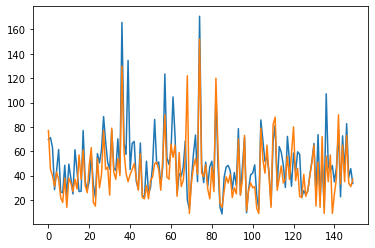

In [97]:
plt.plot(model(torch_test_x.cuda()).cpu().detach().numpy()[1000:1150])
plt.plot(np.array(torch_test_y)[1000:1150])
plt.show()
# 테스트 데이터에 대한 결과물의 일부를 그래프로 확인 할 수 있습니다.